<a href="https://colab.research.google.com/github/javedbaig/text-reading-in-the-wild/blob/main/SOTA_Bengali_Digit_Recognizer_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bangla Digit Recognizer

In [1]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras import backend as k
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Process the data

Our dataset comes from six different source.

In [2]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=32 # The images will be resized to 28x28 pixels

In [ ]:
#data_dir=os.path.join('..','NumtaDB_with_aug')
#paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
#paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
#paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
#paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
#paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
#paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e
#
#paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
#paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
#paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
#paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
#paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
#paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
#paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
#paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
#paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc
#
#path_label_train_a=os.path.join(data_dir,'training-a.csv')
#path_label_train_b=os.path.join(data_dir,'training-b.csv')
#path_label_train_e=os.path.join(data_dir,'training-e.csv')
#path_label_train_c=os.path.join(data_dir,'training-c.csv')
#path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [31]:
paths_train_a = glob.glob(os.path.join('/content/train_a','*png'))
paths_test_a = glob.glob(os.path.join('/content/test-a','*png'))

In [48]:
paths_test_a[0]

'/content/test-a/a00016.png'

In [56]:
img=cv2.imread(paths_train_a[0],cv2.IMREAD_GRAYSCALE)

In [60]:
img=cv2.resize(img,(RESIZE_DIM,RESIZE_DIM),interpolation=cv2.INTER_AREA)

In [63]:
gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
img = cv2.filter2D(img, -1, kernel)

In [64]:
img

array([[202, 204, 218, ..., 219, 212, 227],
       [248, 246, 221, ..., 255, 238, 221],
       [216, 216, 237, ..., 215, 217, 219],
       ...,
       [218, 205, 232, ..., 222, 221, 221],
       [224, 240, 255, ..., 232, 233, 224],
       [218, 215, 200, ..., 230, 221, 222]], dtype=uint8)

In [ ]:
plt.imshow(img)

In [32]:
paths_train_all = glob.glob(os.path.join('/content/train_a','*png'))
paths_test_all = glob.glob(os.path.join('/content/test-a','*png'))


In [84]:
path_label_train_a = ('/content/training-a.csv')

In [72]:
path_label_train_a.loc[0]

filename                                 a00000.png
original filename         Scan_58_digit_5_num_8.png
scanid                                           58
digit                                             5
database name original                        BHDDB
contributing team                      Buet_Broncos
database name                            training-a
Name: 0, dtype: object

### Image Processing

We shall write some helper functions to process and visualize the images. We will convert color to gray scale image. For better understanding we will unblur the image and make image sharp by using laplacian filter.

In [153]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
        #img = cv2.bilateralFilter(img,9,75,75)
        #img = cv2.medianBlur(img,5)
        #img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
        #img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # cnahging colorspace to GRAY
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
        #X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0) #unblur
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv2.filter2D(img, -1, kernel)
        #thresh = 200
        #maxValue = 255
        #th, img = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY);
        ret,img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)

    X=np.array(X) # tranform list to numpy array
    new_label = path_label
    if  new_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename')
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument.
            It will plot the image and its true label. If the image is plotted after prediction
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument.
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=int(np.ceil(n_sample/n_per_row))
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])),
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

Next we are going to use the `get_data()` function to process all the images from dataset

In [86]:
X_train_a, y_train_a = get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)


processed 300/300


In [91]:

X_train_a.shape, y_train_a.shape

((300, 32, 32), (300, 10))

In [92]:
X_train_all=X_train_a

Let's see some samples of the processed data. The digits are more sharp now

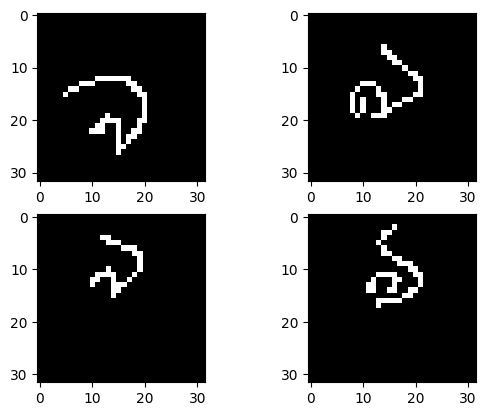

In [93]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

**Histogram of digit**

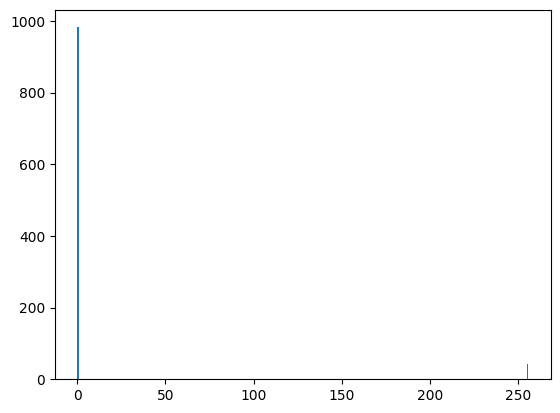

In [94]:
imgg=X_train_all[1]
hist = cv2.calcHist([imgg],[0],None,[256],[0,256])
plt.hist(imgg.ravel(),256,[0,256])

# show the plotting graph of an image

plt.show()

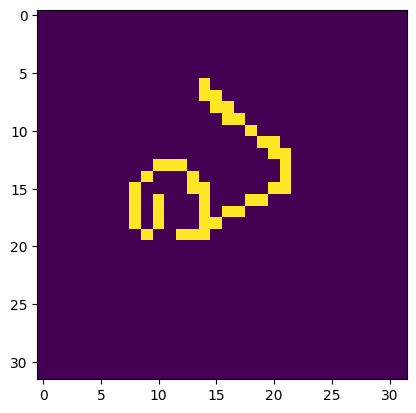

In [95]:
plt.imshow(X_train_all[1])

In [ ]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)

In [ ]:
#X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
#X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
#X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
#X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
#X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
#X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
#X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
#X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [96]:
X_test_a.shape

(84, 32, 32)

In [98]:
X_test_all=X_test_a

In [99]:
X_tshow_all=X_test_all
X_tshow_all.shape

(84, 32, 32)

We will now convert image to 1 color channel

In [100]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],32, 32,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],32, 32,1).astype('float32')

In [101]:
X_train_all.shape

(300, 32, 32, 1)

**Normalize data**

In [102]:
X_train_all = X_train_all/255
X_test_all=X_test_all/255

Next, we are going to randomly choose 80% of the training data and use it to train our neural network. The remaining 20% images are going to be our validation data.

In [119]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]]
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]]
y_val=y_train_all[indices[-(len(indices)-ind):]]

In [120]:
X_train.shape

(240, 32, 32, 1)

## Step 2: Design the model

In [118]:
def my_model(img_size=32,channels=1):
    model = Sequential()
    input_shape = (img_size,img_size,channels)
    model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()

    return model
model=my_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       36992     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                 

## Step 3: Train the model

In [108]:
from tensorflow.keras import backend as K

In [123]:
path_model='model_filter.h5' # save model at this location after each epoch
#K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,
            y=y_train,
            batch_size=64,
            epochs=100,
            verbose=1,
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 1.4639 - accuracy: 0.6708 - val_loss: 1.4905 - val_accuracy: 0.9000
Epoch 2/100
4/4 [==============================] - 6s 1s/step - loss: 0.8023 - accuracy: 0.8875 - val_loss: 0.7908 - val_accuracy: 0.9000
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 0.6637 - accuracy: 0.8750 - val_loss: 0.3549 - val_accuracy: 0.9000
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 0.4874 - accuracy: 0.9000 - val_loss: 0.3622 - val_accuracy: 0.9000
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.3952 - accuracy: 0.9000 - val_loss: 0.3875 - val_accuracy: 0.9000
Epoch 6/100
4/4 [==============================] - 6s 2s/step - loss: 0.4097 - accuracy: 0.8917 - val_loss: 0.3164 - val_accuracy: 0.9000
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 0.3900 - accuracy: 0.9000 - val_loss: 0.3408 - val_accuracy: 0.9000
Epoch 8/100
4/4 [=================

# After 30 epochs we have a decent training and valiadation accuracy on dataset.

## Result Analysis

Let's observe the images by our model.

In [124]:
predictions_prob=model.predict(X_test_all) # get predictions for all the test data

3/3 [==============================] - 1s 129ms/step


In [155]:
n_sample=25
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

In [156]:
ind

array([51, 14, 71, 60, 20, 82, 74, 74, 23,  2, 21, 52,  1, 29, 37,  1, 63,
       59, 20, 32, 75, 57, 21, 48, 58])

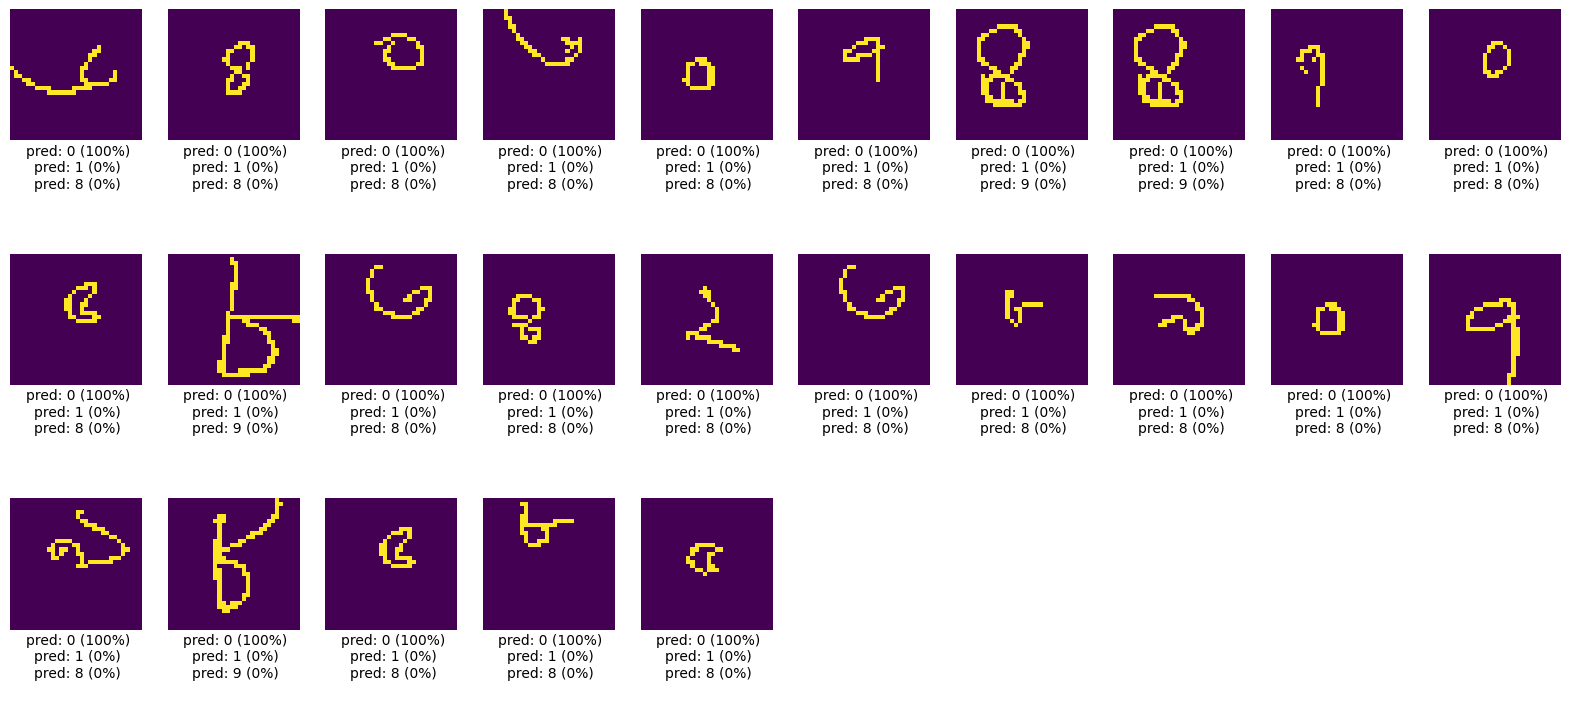

In [157]:
imshow_group(X=X_tshow_all[ind],y=None,y_pred=predictions_prob[ind], phase='prediction')

In [138]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [139]:
keys=[get_key(path) for path in paths_test_all ]

In [142]:
create_submission(predictions=labels,keys=keys,path='submission7.csv')

In [143]:
prediction = pd.read_csv('submission7.csv')
prediction.head(100)

,key,label
0,a00016.png,0
1,a00082.png,0
2,a00075.png,0
3,a00063.png,0
4,a00027.png,1
...,...,...
79,a00065.png,0
80,a00024.png,0
81,a00038.png,0
82,a00072.png,0


In [ ]:
#df=pd.read_csv(path_label_train_c,na_filter=False)
#df.head(100)

In [ ]:
#y=np.array(df.iloc[:,3:4])
#print(y)
